In [1]:
! pip install pymc

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve

# 
# import warnings
# 
import arviz as az
import pymc as pm
# import theano.tensor as tt

In [4]:
class A_dist():
    def __init__(self, Beta):
        self.beta = Beta
        self.df = pd.DataFrame(columns = ['beta_hat', 'sample_size', 'initial_guess'])
        self.result = pd.DataFrame()
    
    def pdf(self, x):
        if(x <= 0): return 0
            
        c = self.beta/x
        if(c > 10): return 0
        pdf = (x**-2) * np.exp(((1 - np.exp(c))/self.beta) + c)
        return pdf

        
    def cdf(self, x):
        if(x <= 0): return 0

        c = self.beta/x
        if(c > 10): return 0
        # cdf = np.exp((1 - np.exp(c))/self.beta)
        log_cdf = (1 - np.exp(c))/(self.beta)
        return np.exp(log_cdf)

        
    def plot(self):
        fig, axs = plt.subplots(1, 2, figsize=(15,7))
        tolerance = 10**-2

        ax = axs[0]

        x = np.linspace(10**-5, 30, 1000)     
        ax.plot(x, [self.pdf(value) for value in x])
        ax.set_title('PDF')
        
        ax = axs[1]
        lim_sup = 1
        while((1 - self.cdf(lim_sup)) > tolerance): lim_sup+=1
    
        x = np.linspace(10**-5, lim_sup, 1000)     
        ax.plot(x, [self.cdf(value) for value in x])
        ax.set_title('CDF')
        plt.show()
        
    
    def MLE(self, x_values, **kwargs):
    
        initial_guess = kwargs['initial_guess']
        def estimator(beta):
            sum_X = sum(x**-1 for x in x_values)
            sum_numerator = sum(((beta/x) * np.exp(beta/x)) - np.exp(beta/x) + 1 for x in x_values)
            return sum_X - sum_numerator / (beta**2)
    
        result = fsolve(func=estimator, x0=initial_guess)
        return result[0]
    
    def exp_sample(self, n = 10):
        x = []
        for i in range(n):
            u = np.random.random()
            value = self.beta/np.log(1 - (self.beta* np.log(u)))
            while(value > 100):
                u = np.random.random()
                value = self.beta/np.log(1 - (self.beta* np.log(u)))
            x.append(value)
        return x

    def plot_sample(self, n = 10, lim_sup = 100, **kwargs):
        sample = self.exp_sample(n = n)
        fig, ax = plt.subplots(1, 1, figsize=(15,7))
        
        plt.hist(sample, bins = int(n/2), density=True, alpha=0.5, color='blue', label='Generated Data')
        # lim_sup = max(sample)

        x = np.linspace(0, lim_sup, 1000)
        pdf = [self.pdf(value) for value in x]
        
        plt.plot(x, pdf, color='red', label='Theoretical PDF')
        
        ax.set_xlim(0,100)
        plt.xlabel('Random Variable')
        plt.ylabel('Probability Density')
        plt.title('Random Variables using Inverse Transformation')
        plt.legend()
        plt.grid(True)
        
        plt.show()
        
        beta_hat = self.MLE(x_values = sample, **kwargs)
        print(f"Valor estimado para beta:{beta_hat:.2f}")
        
        return sample

    def run_experiment(self, n_rep : int, sample_sizes : list, initial_guess : list, applyGap = True):
        
        for sample_size in sample_sizes:
            for guess in initial_guess:
                for rep in range(n_rep):
                    sample = self.exp_sample(n = sample_size)
                    beta_hat = self.MLE(x_values = sample, initial_guess = guess)

                    self.df.loc[len(self.df)] = [beta_hat, sample_size, guess]
                    # print(beta_hat)
                    
        self.result = self.df.groupby(['sample_size', 'initial_guess'])['beta_hat'].agg(['mean', 'std']).reset_index()
        
        
        fig, axs = plt.subplots(1, 2, figsize = (15,7))
        
        ax = axs[1]
        for i, guess in enumerate(self.result['initial_guess'].unique()):
            data = self.result.loc[self.result['initial_guess'] == guess]     
            plt.errorbar(data['sample_size'] + i*(5 if applyGap else 0), data['mean'], yerr=data['std'], fmt='-o', capsize=5, label = guess)
        
        ax.legend()
        ax.set_title(f"Estimation of the Beta parameter - True value = {self.beta}")
        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Beta_hat')
        
        ax = axs[0]
        ax = fig.add_subplot(121, projection='3d')
        for i, guess in enumerate(self.result['initial_guess'].unique()):
            data = self.result.loc[self.result['initial_guess'] == guess]
            ax.plot(data['sample_size'], [guess] * len(data), data['mean'], label=f'Initial Guess {guess}', marker='o')

        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Initial Guess')
        ax.set_zlabel('Beta_hat')
        ax.legend()

        # ax.set_title(f"Estimation of the Beta parameter - True value = {self.beta}")
        ax.set_title("TEM QUE TIRAR A CAIXA AO REDOR DO PLOT!")
        plt.tight_layout()
        plt.show()

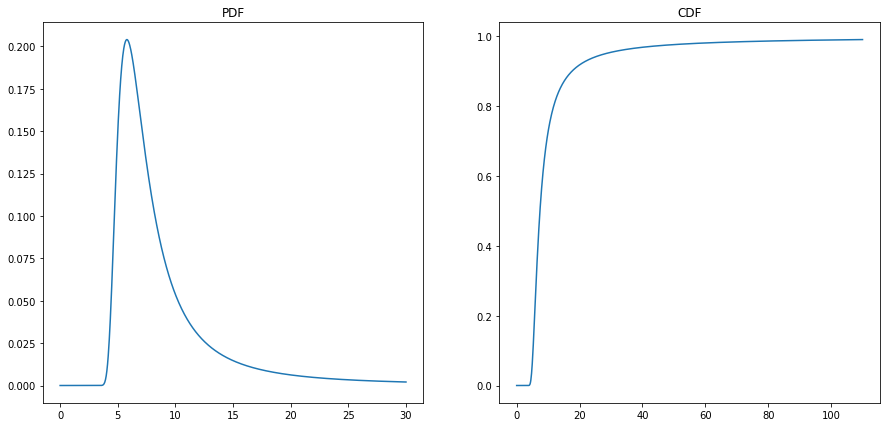

In [5]:
a = A_dist(20)
a.plot()
# a.MLE()

C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


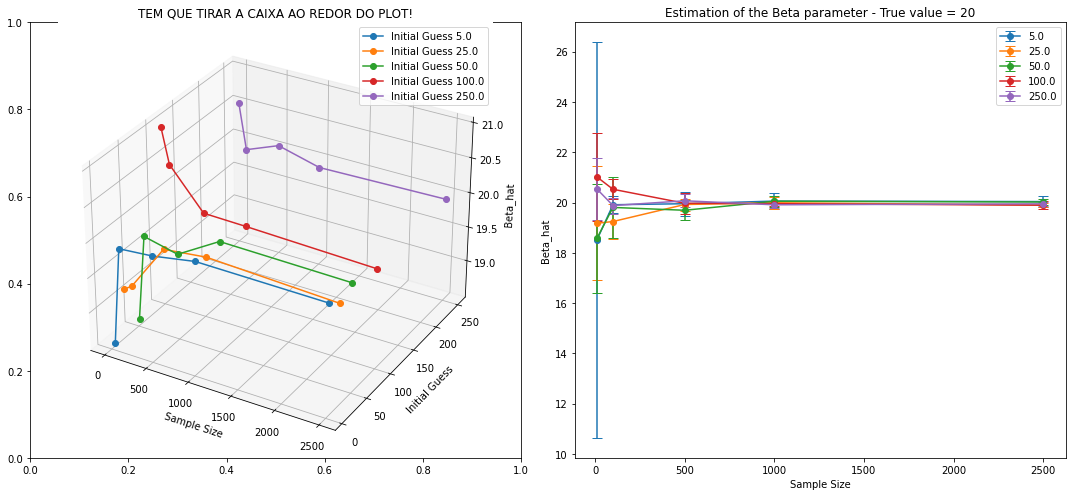

In [5]:

a.run_experiment(n_rep=5, sample_sizes = [10, 100, 500, 1000, 2500], initial_guess=[5, 25, 50, 100, 250], applyGap = False)

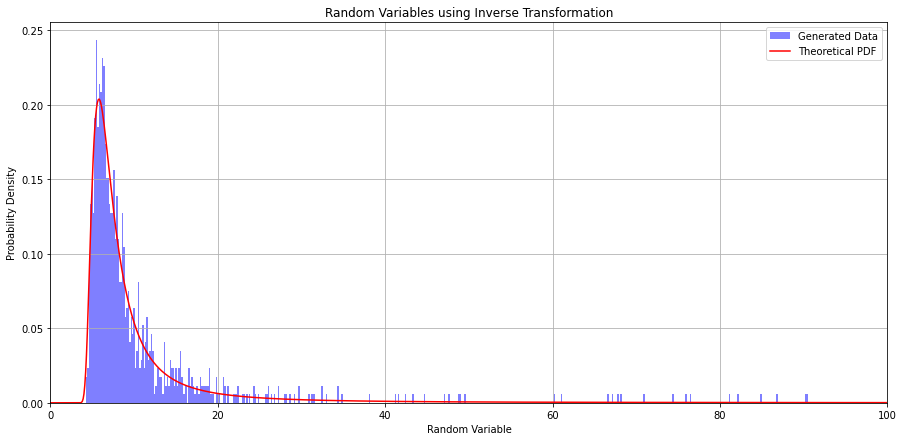

Valor estimado para beta:20.47


(1000, 90.51456326108203)

In [6]:
x = a.plot_sample(n=1000, lim_sup=100, initial_guess = 100)
len(x), max(x)

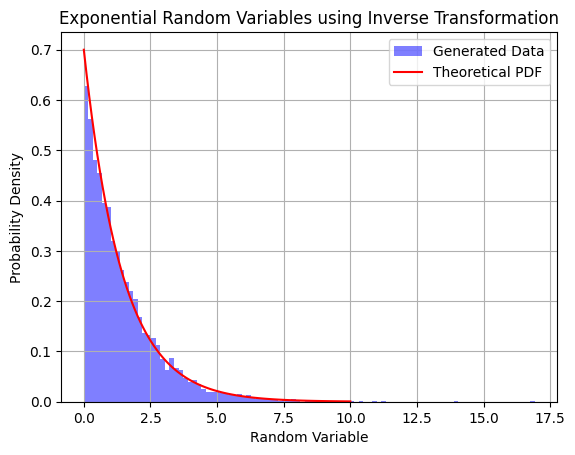

In [6]:
def exponencial_sample(alpha, n = 10):
    x = []
    for i in range(n):
        u = np.random.random()
        x.append(-np.log(1-u)/alpha)

    return x

n = 500
alpha = .7


sample = exponencial_sample(alpha = alpha, n = 5000)
plt.hist(sample, bins = 100, density=True, alpha=0.5, color='blue', label='Generated Data')

x = np.linspace(0, 10, 100)
pdf = alpha * np.exp(-alpha * x)

plt.plot(x, pdf, color='red', label='Theoretical PDF')
plt.xlabel('Random Variable')
plt.ylabel('Probability Density')
plt.title('Exponential Random Variables using Inverse Transformation')
plt.legend()
plt.grid(True)

plt.show()


In [8]:
# Dados banco - Leitura dos dados
dados = pd.read_csv('https://raw.githubusercontent.com/cibelerusso/IntroducaoaInferenciaEstatistica/main/Dados/amostra_banco.csv', index_col=0, decimal=',')

dados.head()

,Cliente,Sexo,Idade,Empresa,Salario,Saldo_cc,Saldo_poupança,Saldo_investimento,Devedor_cartao,Inadimplente
33227,33227,M,38,Privada,6467,993.18,0.0,0.0,2038.32,1
64805,64805,M,33,Privada,5764,1167.27,0.0,0.0,4617.05,1
39764,39764,F,35,Privada,5417,667.3,0.0,0.0,5726.83,1
51271,51271,M,36,Privada,5858,846.53,0.0,0.0,1723.74,1
9699,9699,M,32,Privada,5579,768.9,16801.57,8138.71,0.0,0


In [9]:
with pm.Model() as model:
    p = pm.Beta("p", 2, 8) #distribuição a priori para p

    #verossimilhança de X
    obs = pm.distributions.discrete.Bernoulli("obs", p, observed=dados['Inadimplente'])

    # amostrando da distribuição a posteriori
    idata = pm.sample(2000, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 28 seconds.


In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.241,0.019,0.204,0.275,0.0,0.0,3395.0,5440.0,1.0


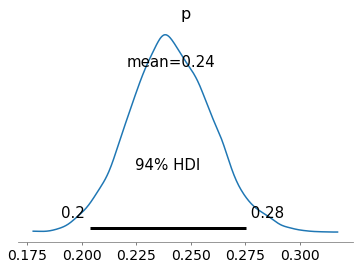

In [11]:
az.plot_posterior(idata);

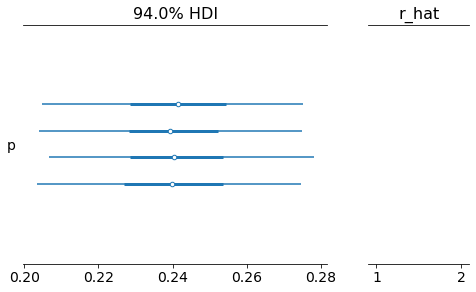

In [12]:
az.plot_forest(idata, r_hat=True);

In [13]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

In [16]:
model.basic_RVs, model.free_RVs, model.observed_RVs

([mu ~ Normal(0, 1), obs ~ Normal(mu, 1)],
 [mu ~ Normal(0, 1)],
 [obs ~ Normal(mu, 1)])

In [17]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

x

x ~ Normal(0, 1)

In [18]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(2000, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 24 seconds.


In [19]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(cores=4, chains=6, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [mu]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 36 seconds.


In [20]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [22]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    idata = pm.sample(10000, step=[step1, step2], cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 25 seconds.


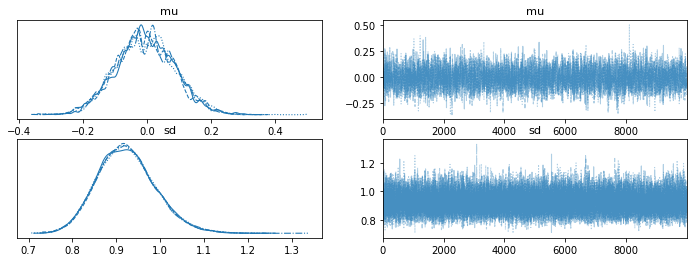

In [23]:
az.plot_trace(idata);

In [37]:
class CustomDistribution(pm.Continuous):
    def __init__(self, beta, **kwargs):
        super().__init__(**kwargs)
        # self.c = c
        self.beta = beta

    def logp(self, x):
        return -2 * pm.math.log(x) + ((1 - pm.math.exp(self.c)) / self.beta) + self.c

    def random(self, size=None):
        return np.random.power(2, size=size)

with pm.Model() as model:
    c = pm.Normal('c', mu=0, sigma=1)
    beta = pm.HalfNormal('beta', sigma=1)
    # custom_dist = CustomDistribution('custom_dist', beta=beta)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [42]:
import pymc as pm
import numpy as np

# Define your custom PDF
def custom_pdf(x, beta):
    if(x <= 0): return 0
            
    c = beta/x
    if(c > 10): return 0
    pdf = (x**-2) * np.exp(((1 - np.exp(c))/beta) + c)
    return pdf

custom_pdf(2, 5)

0.3253697167360137

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


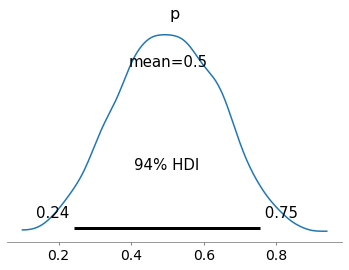

In [53]:
# Assume 10 trials and 5 successes out of those trials
# Change these numbers to see how the posterior plot changes
trials = 10; successes = 5

# Set up model context
with pm.Model() as coin_flip_model:
    # Probability p of success we want to estimate
    # and assign Beta prior
    p = pm.Beta("p", alpha=1, beta=1)
    
    # Define likelihood
    obs = pm.Binomial("obs", p=p, n=trials,
        observed=successes,
    )

    # Hit Inference Button
    idata = pm.sample()

az.plot_posterior(idata, show=True);